# Full Correlation Matrix Analysis
[Contributions](#contributions)

The connectivity analyses we performed previously examined the coupling of different regions of the brain. This coupling can capture information that activity-based univariate or multivariate techniques do not detect. For instance, imagine that voxel A and B are coupled during one task condition and voxel A and C are coupled during another task condition. In such a case, voxel A may always be active (and thus task differences are likely to be invisible to activity-based approaches _including MVPA_), but its connectivity with other voxels will reveal task information.

However, this creates a problem: to find these diagnostic voxels in an unbiased, data-driven fashion it is necessary to correlate every voxel in the brain with every other voxel and somehow analyze these millions or billions of pairwise correlations. This computation can take a very long time. Simplifying assumptions can be made to reduce the complexity of this analysis. For instance, it is possible to downsample the voxels (e.g., using parcellation as in the previous session) in order to reduce the total number of correlations that are made, but in doing so we introduce the assumption that those parcellations divide functional units of brain activity.

Fortunately, advances in machine learning, parallel computing and efficient coding have made it possible to calculate and analyze billions of correlations rapidly. These tools are part of the [BrainIAK toolbox](http://brainiak.org/) and are used for Full Correlation Matrix Analysis (FCMA). This method is outlined in detail in [Wang et al. (2015)](http://ntblab.yale.edu/wp-content/uploads/2015/06/Wang_JNM_2015.pdf). In what follows we will learn how to run FCMA and actually perform it on real data on a reasonable timescale.

The logic of FCMA is as follows: take every voxel in the brain and correlate it with every other voxel in the brain for each trial and participant. Then, take each big correlation matrix and turn it into a vector so that every pairwise relationship is represented as an element in that vector. This vector is a list of features that can be used for classification, just like we used voxels or principal components in past exercises. The vectors for each trial/condition can then be stacked so that we get an example by feature matrix. We can then feed that matrix into a classifier and determine whether the pattern of information across voxel pairs discriminates between conditions.  

We will use FCMA to determine if there exist brain regions, undetectable by MVPA, that show differential processing of attending to faces vs. scenes. We can compare our results from FCMA to the MVPA results that were generated in the searchlight notebook.


## Goal of this script
1. Run FCMA feature selection
2. Run FCMA classification
3. Learn plotting tools for FCMA

## Table of Contents
[1. The FCMA workflow](#fcma_wf)  
>[1.1 Data preparation](#data_prep)  
>[1.2 Create an epoch file](#epoch)  
>[1.3 Normalize data](#prep_for_fcma)  
>[1.4 Compute correlations and voxel selection](#vox_sel)  
>[1.5 Create voxel selection masks](#masks)  
>[1.6 Classification](#classify)  
>>[1.6.1 Pre-computed kernel](#precomputed) 

[2. FCMA batch scripts](#fcma_batch)
>[2.1 Inner loop (three subjects)](#fcma_inner)  
>[2.2 Outer loop (all subjects)](#fcma_outer)  
>[2.3 Permutation testing](#fcma_perm)  

[3. Plotting the results](#plot) 
>[3.1 Plot the connectome](#connectome)  
>[3.2 Plotting circos](#circos)  

[4. MVPA and FCMA](#mvpa) 

### Exercises:  
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9) 
>[Novel contribution](#novel) 


### Dataset <a id="data-set"></a> 

For this script we will use the face/scene dataset from [Wang et al. (2015)](https://doi.org/10.1016/j.jneumeth.2015.05.012), who in turn used localizer data from [Turk-Browne et al. (2012)](https://doi.org/10.1523/JNEUROSCI.0942-12.2012). Localizer details (Turk-Browne et al. (2012):

"Subjects also completed a functional localizer run lasting 6 min 6 s to define bilateral PPA regions of interest (ROIs). An ROI approach was used to minimize multiple comparisons and improve statistical power. The localizer run alternated between six repetitions each of scene and face blocks (Turk-Browne et al., 2010). Blocks contained 12 stimuli presented for 500 ms every 1500 ms. The 18 s of stimulation was followed by 12 s of fixation before the next block. Subjects made the same indoor/outdoor judgment for scenes, and a male/female judgment for faces."

**Self-study:** Explore the data

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Import libraries
import nibabel as nib
import numpy as np
import time
import os
from scipy.stats import sem

from nilearn import plotting
from nilearn.image import coord_transform

import brainiak.utils.fmrisim as sim
from brainiak.fcma.voxelselector import VoxelSelector
from brainiak.fcma.preprocessing import prepare_fcma_data
from brainiak.fcma.preprocessing import RandomType
from brainiak.fcma.util import compute_correlation
from brainiak import io

import networkx as nx
from nxviz.plots import CircosPlot

import matplotlib.pyplot as plt
import seaborn as sns 

# %matplotlib inline 
%matplotlib notebook
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds



## 1. The FCMA workflow <a id="fcma_wf"></a>

The following sequence of steps are necessary for successfully running FCMA using BrainIAK. 

1. [Data preparation](#data_prep) 

2. [Create an epoch file](#epoch)
    
3. [Normalize data](#prep_for_fcma) 

4. [Correlation and voxel selection](#vox_sel)

5. [Create voxel selection masks](#masks)

6. [Classification](#classify)

### 1.1 Data preparation <a id="data_prep"></a>

FCMA has tools to efficiently read in brain data but to do this, directories must be set up appropriately. Specifically, FCMA takes as an input a directory with the fMRI data you want to analyze. You can specify the suffix of the files you want to read in. Usually the suffix will just be '.nii.gz' but if you want to specify loading in only data from a certain condition then you might want a different kind of suffix. All data within the directory with the matching suffix will be loaded in and analyzed. 

In [2]:
# Set paths
from utils import fs_data_dir, results_path

print('data dir = %s' % (fs_data_dir)) 
suffix = 'bet.nii.gz'
mask_file =  os.path.join(fs_data_dir, 'mask.nii.gz') # whole brain data
epoch_file = os.path.join(fs_data_dir, 'fs_epoch_labels.npy')

# Make directory to save results
output_dir = results_path + '/fcma_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print('output dir = %s' % (output_dir)) 

data dir = /Users/aratzan/Downloads/brainiak_datasets/face_scene
output dir = /Users/aratzan/brainiak_results/fcma_results


In [3]:
# Create an image object that can be used by FCMA to load in data efficiently.
images = io.load_images_from_dir(fs_data_dir, suffix)

# Use a path to a mask file to create a binary mask for FCMA
mask = io.load_boolean_mask(mask_file)

### 1.2 Load an epoch file <a id="epoch"></a>

What is an epoch? For the purposes of the FCMA package, an epoch is a time-interval that you want to carve up for analysis. FCMA needs to know which timepoints in the data correspond to which events, much like using labels in the previous notebooks. In notebook-08 (seed-based connectivity) our epochs were the entire run of data but in the code here this is just each block of faces or scenes. The stimuli were shown only for 12 TRs (18s) followed by 6 TRs (12s) of rest. We will use 12 TRs as the epoch for FCMA.

The epoch file has a very specific structure that makes it readable by BrainIAK. The epoch file is a list of participants/runs (here the same thing) in which each entry is a 3-D matrix of booleans, with the value =1 for all TRs for the epoch of interest and zero everywhere else. The dimensions of the 3-D matrix are condition (face or scene) by epoch (trial 1, 2, etc.) by TR. This means that for each condition and epoch, there is a vector of TR-length that represents whether any time points from this data ought to be included. 

**Note:** the epoch file in this example isn't actually a list of participants, it is a 4-D array with the first dimension representing the participants. However, it could be a list and would be interpreted the same way. The reason you might want a list instead of a 4-D volume is that different participants may have different numbers of TRs.

**Exercise 1:**<a id="ex1"></a> Crop the epoch file to extract the first 3 subjects. Do this by first loading in the current epoch file using numpy tools. Then edit this file to only include 3 participants and save this cropped version as `fs_epoch_labels_3subj.npy`. Then read in the epoch file with the [io.load_labels](http://brainiak.org/docs/brainiak.html?highlight=io#module-brainiak.io) tool.

How many epochs are there per person and how many epochs of each condition there are?

In [4]:
# Insert code here
# load 'epoch_file'

#load in using numpy 
print(epoch_file)

epoch_array = np.load(epoch_file)
print(epoch_array.shape) # shape = 18 x 2 x 12 x 244
print(epoch_array[:3].shape)

# uncomment the following lines and fill-in the blanks
# # crop the numpy array, only include 3 participants 
new_epoch_array = epoch_array[:3]


# # save the cropped array 
new_epoch_file = os.path.join(output_dir, 'fs_epoch_labels_3subj.npy')
np.save(new_epoch_file, new_epoch_array)


# # read in the epoch file using io.load_labels
epoch_list = io.load_labels(new_epoch_file) # It has 3 subjects



# # print out useful information
epochs_per_subj = epoch_list[0].shape[1]
print('Number of participants:', len(epoch_list))
print('Number of epochs per participant:', epochs_per_subj)
#looks good 

/Users/aratzan/Downloads/brainiak_datasets/face_scene/fs_epoch_labels.npy
(18, 2, 12, 244)
(3, 2, 12, 244)
Number of participants: 3
Number of epochs per participant: 12


**A:** 3 participants, 12 epochs per person, 2 conditions (6 epochs of each?)

### 1.3 Normalize data<a id="prep_for_fcma"></a>

BrainIAKs FCMA function takes in the brain images, mask and epoch file via the [prepare_fcma_data](http://brainiak.org/docs/brainiak.fcma.html?highlight=prepare_fcma#brainiak.fcma.preprocessing.prepare_fcma_data) function to format and normalizea the data for analysis. You might wonder why this step is not included in the actual FCMA function. Why bother with a dedicated preparation step? The rationale behind this is that it helps in speeding up the correlation computation. As such it is a necessary step to use BrainIAKs optimized processing routines.

Note that this function has a nice feature: if your input `epoch_list` has fewer entries than your input `images` then it will only take the first N images for which entries in the `epoch_list` exist. This is useful for what we are doing here: we input an epoch file for three participants only, while inputting an BrainIAK image object with fMRI data for all participants. In other words, if the `epoch_list` is subsampled then your `images` will also be subsampled. However, make sure you have the order right: It will only take the first N participants so make sure your epoch file corresponds to those same participants.

In [5]:
# Normalize and format the data.
raw_data, _, labels = prepare_fcma_data(images, epoch_list, mask)


In [6]:
print(raw_data[0].shape) # 36 x 12 x 34470, len 36, arrays correspond to activatin within each TR of each epoch 
print(labels) #len 36, 0 or 1 corresponds to condition

(12, 34470)
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


**Exercise 2:**<a id="ex2"></a> What does each list element of raw_data and labels represent? What does the dimensionality of the array in each raw_data list element represent?

**A:** 36 epochs, 12 TRs, 34470 voxel data points for all time 


### 1.4 Compute correlations and voxel selection <a id="vox_sel"></a>
The computational workhorse behind FCMA is the code in [compute_correlation](http://brainiak.org/docs/brainiak.fcma.html?highlight=compute_correlation#brainiak.fcma.util.compute_correlation). This is C code written with [cython](http://cython.org/) (a Python binding for C code) that allows for extremely efficient computation of correlations.

The following example extracts the data for one epoch, for one subject and computes the correlation using this procedure.

Analysis duration: 0.02068s


<IPython.core.display.Javascript object>


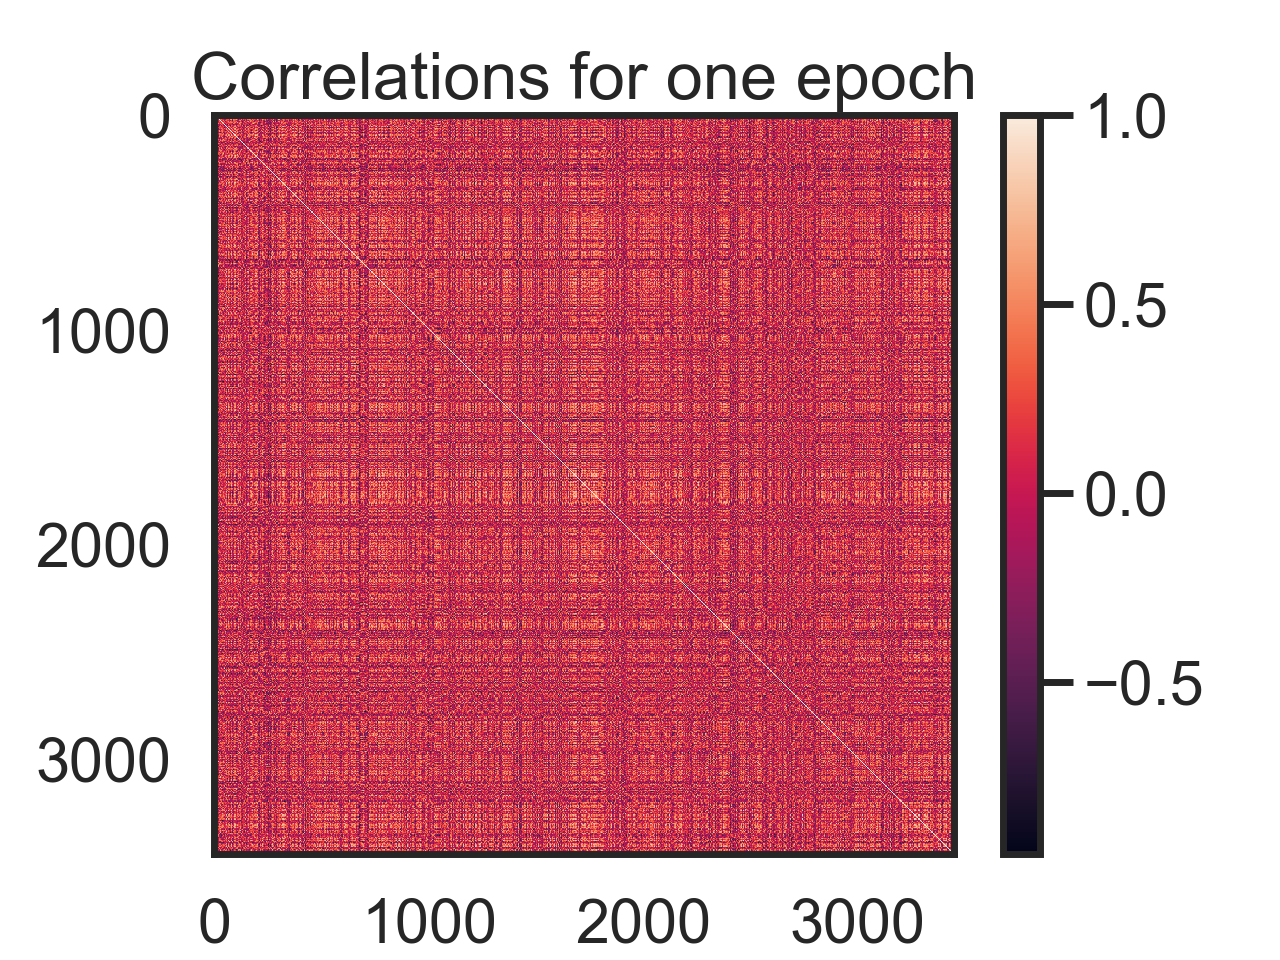

In [7]:
# Extract data for one subject, for one epoch (take only the every 10th voxel)
epoch_data = raw_data[0][:,::10]

# Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
mat = np.ascontiguousarray(epoch_data.T, dtype=np.float32)  # Voxels x TRs for one epoch

begin_time = time.time()
epoch_corr = compute_correlation(mat, mat)  # correlation of every voxel with every other voxel
end_time = time.time()
print("Analysis duration: %0.5fs" % (end_time - begin_time))

plt.figure()
plt.title('Correlations for one epoch');
plt.xlabel('voxels');
plt.imshow(epoch_corr);
plt.colorbar()

**Exercise 3:**<a id="ex3"></a> What are the inputs to the [compute_correlation](http://brainiak.org/docs/brainiak.fcma.html?highlight=compute_correlation#brainiak.fcma.util.compute_correlation) function and what is the main trick this function pulls to speed up computation?  

**A:**

**Voxel selection**

To understand how voxel selection in FCMA works, remember what we did in a previous exercise on classifier optimization in which we learned different ways to perform cross-validation. When doing cross-validation, one option is to leave out some of your data such as a run or a participant while you fit parameters or select voxels. In FCMA, it is typical to perform nested cross-validation in which we leave out a participant for final testing on an outer loop (e.g., participant 18) and perform voxel selection with cross-validation on an inner loop with another participant left out to quantify feature selection performance (e.g., participant 17) and the rest used to conduct feature selection (e.g., participants 1-16). Thus, for each of 18 outer-loop folds, there are 17 inner-loop folds. To use this approach we simply ignore one subject's data before executing the voxel selection procedure (the inner loop itself). We can then use that data for final classifier testing. Then, on new iterations of the outer loop we can rotate which participants are to be ignored.

The inner loop voxel selection procedure consists of computing correlation matrices and the classification of correlation patterns. This is highly computationally demanding and has been optimized in BrainIAK, where the [VoxelSelector](http://brainiak.org/docs/brainiak.fcma.html?highlight=voxel%20selector#module-brainiak.fcma.voxelselector) method implements this massive computation (all voxels by all training subjects by all epochs). How does it work?

1. First, `VoxelSelector` uses the `compute_correlation` function to compute the correlation of every voxel with every other voxel in the brain for each epoch and participant in the training set. 
2. It then trains a classifier for each voxel on a training set consisting of all epochs of n-1 participants. Each voxel's classifier uses the voxel's correlation values with all other voxels in the mask as features (as if it were a seed). 
3. Finally, it tests the classifier on the nth participant in the training set. 

This is repeated for `n` inner-loop folds of cross-validation and the accuracies are averaged across folds for each voxel. We can then rank voxels in terms of overall performance and use this ranking as a way to select which voxels have discriminative connectivity in the training set.

**Exercise 4:**<a id="ex4"></a> Split the `raw_data` and `labels` variables created by `prepare_fcma_data` into training and testing set. Make subject 2 as the testing set and subject 1,3 as the training set. Print out the shape of `raw_data` and `labels` in training and testing set to confirm your answer.

In [14]:
# Insert code here

raw_data = np.asarray(raw_data)
print(raw_data.shape)

raw_data_testing = raw_data[12:24]

raw_data_training = np.concatenate((raw_data[0:12], raw_data[24:36]), axis = 0) 


labels_testing = labels[12:24]
labels_testing = np.asarray(labels_testing) 
labels_training = np.concatenate((labels[0:12], labels[24:36]))

print("train data: ", raw_data_training.shape)
print("test data: ", raw_data_testing.shape)

print(labels_training.shape)
print(labels_testing.shape)


#how does raw_data correspond to each participant 
#0-12, 12-24, 24-36

#how do labels correspond to each participant 

(36, 12, 34470)
train data:  (24, 12, 34470)
test data:  (12, 12, 34470)
(24,)
(12,)


**How FCMA works on a computer or cluster**

The FCMA implementation in BrainIAK efficiently parallelizes and disseminates the computation amongst the resources available. Below is a figure detailing the workflow of FCMA. The figure caption is quoted below:

![image](https://ars.els-cdn.com/content/image/1-s2.0-S0165027015001910-gr1.jpg)
>"Fig. 1. Workflow overview. FCMA uses a controller/worker architecture, in which each worker first loads the full data into memory. The full data consist of a matrix with V voxels in rows and T timepoints in columns; the timepoints can be subdivided into E epochs, each with TE timepoints (inset depicts two voxels and epochs). The controller process does the following: assigns a subset S of voxels to each of W workers; instructs the worker to compute the correlation between each of these voxels and the rest of the brain in each epoch; instructs the worker to analyze the correlation vectors for each voxel across epochs with MVPA and supplied condition labels; collects the analysis result (i.e., cross-validation accuracy) for each voxel and loads it into memory; and returns to the first step to assign another subset of voxels until there are none left. Finally, the controller writes the results to disk." Source:  [Wang et al. (2015)](https://doi.org/10.1016/j.jneumeth.2015.05.012)

This computation cannot be run within a notebook because the controller and worker relationship needs at least two processors to run; whereas we are currently only using one for this notebook.

Instead we provide some [batch scripts](#fcma_batch) to execute the whole sequence of the FCMA workflow. However, the code isn't scary and actually does something quite similar to what we have done before with [scikit-learn](http://scikit-learn.org/stable/) for classification: we create a classification object with the inputs we desire, specify the classification kernel and then run it, like this:

`vs = VoxelSelector(labels, epochs_per_subj, num_subjs, raw_data)`  
`clf = SVC(kernel='precomputed', shrinking=False, C=1)`  
`results = vs.run(clf)`  

### 1.5 Create voxel selection masks <a id="masks"></a>

When we have each voxel labeled in terms of its average accuracy across inner loop folds we can then choose how many voxels we wish to include in building our classifier model to test the left-out outer-loop participant. This is a feature selection step just like we did with classifiers in previous notebooks. Unlike there, where it was relatively easy to do feature selection (e.g., PCA), here the analyses are computationally and memory intensive and so we need to save intermediate steps. Regardless, the logic is the same: find the voxels that we think will be most useful in our classification of a held-out, never-before-seen, subject. 

**Note:** We sometimes call the volumes created during feature selection 'masks'. Mask is used to describe a binary volume the shape of our data that can be used to select the voxels we care about. We typically use masks just to select all the brain voxels (i.e., a whole-brain mask) but the logic of masking also applies to feature selection: we can use this volume to pull out only the voxels we care about for classification.

The bash script we use here calls [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL) commands to choose a subset of voxels (top N) and create a binary mask for each training set/outer-loop fold. As you should be able to see, it creates three types of files:
1. For each input volume (i.e., participant), a mask for the top N voxels is created (`fc_no${ppt}_result_seq_top${voxel_number}.nii.gz`)
2. These individual masks are then concatenated, resulting in an array in which each element in 4 dimensions is a top-N-voxel volume mask (`all_top${voxel_number}.nii.gz`)
3. This concatenated array is used to create one map which gives the probability for each voxel to be included in the top N (`prop_top${voxel_number}.nii.gz`). i.e., if the same voxel is in all participants' masks then it will have a value of 1, if a different voxel is in 1 out of 10 participants' masks it will have a value of 0.1.

**Self-study:** Try to understand what happens in the script below. Here are some hints: \${voxel_number} is the number of voxels included. `fslmerge` has the following input structure: 'fslmerge -t \$output_name \$input_1 \$input_2 ... $input_N'. The last line that calls *fslmaths* creates the prop_top volume by doing a computation on the all_top volumes.

In [15]:
!cat ./09-fcma/make_top_voxel_mask.sh

#!/bin/bash -i
#
# Takes in a results directory from fcma analysis and a certain number of voxels to threshold for a mask as input

#You will need to load fsl module/conda for your cluster
source ../setup_environment.sh


# Take inputs
input_dir=$1  # What is the path to thedata?
voxel_number=$2  # What voxel threshold would you like to set
output_dir=$3  # Where do you want to put the data

# Create output_dir
if [ ! -d ${output_dir} ]; then
  mkdir ${output_dir}
fi

# Iterate through each volume in the fcma directory
for file in ${input_dir}/*_seq.nii.gz
do	
	# Preprocess the file name
	fbase=$(basename "$file")
	pref="${fbase%%.*}"
	
	# Create the voxel mask
	fslmaths $file -uthr $voxel_number -bin ${output_dir}/${pref}_top${voxel_number}.nii.gz

done

# Concatenate all of the masks from each volume
fslmerge -t ${output_dir}/all_top${voxel_number} ${output_dir}/fc_no*top${voxel_number}.nii.gz

# Create a probability map of each voxel being included across participants
fslmaths ${out

### 1.6 Classification <a id="classify"></a>

On this subset of top N voxels that we have selected, we perform classification of the correlation patterns by first training on the subjects we used for voxel selection (all participants in the training set) and then testing on the held-out outer-loop participant that wasn't used for any previous analyses.

BrainIAK has a special method, called [Classifier](http://brainiak.org/docs/brainiak.fcma.html?highlight=classifier#module-brainiak.fcma.classifier), that will compute correlations on the selected voxels and perform classification in a computationally efficient manner. We have created the script *fcma_classify.py* as a wrapper. This script is similar to the voxel selection script: data are loaded into memory on each processor, then normalized and prepared for input to FCMA, a *Classifier* object is made from the data and then fit. Like voxel selection, this can be called in a similar way to the classification tools from [scikit-learn](http://scikit-learn.org/stable/).

Critically, the mask input to the *fcma_classify.py* is not the whole-brain mask but is instead the top-N voxels that are deemed appropriate for this outer-loop fold. In other words, it is only going to leave the voxels in the brain that we have determined carry information.

As before the code is relatively tractable and familiar; however, again we cannot run this in the notebook because of the need for parallelism. The steps are printed below:

Once our data and labels are arranged into training and test sets we create objects that are ready to be read by FCMA.  If you concatenate the training and testing data then zip it into a single object, this is much more memory efficient. The FCMA code then takes account of how many training samples there are and *never* looks at the test data when fitting the model. This procedure is thus better, although a little harder to understand. 

`training_obj = list(zip(training_data, training_data))`  
`testing_obj = list(zip(testing_data, testing_data))` 

We then create our SVM kernel and Classifier object. You could use many kernels here, you are not constrained to SVM. This Classifier object is then fit to the training data before being tested on the never-before-seen test data.

`svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)`  
`clf = Classifier(svm_clf, epochs_per_subj=epochs_per_subj)`  
`clf.fit(training_obj, training_labels)`  
`predict = clf.predict(testing_obj)`  


Users of FCMA have found it useful to distinguish between intrinsic and extrinsic classification. 

> Intrinsic classification, demonstrated above, is when the correlations of only the voxels in the top_n_mask are used for classification. In other words this method only cares about correlations among those voxels that were selected because they contain information.  

> Extrinsic classification is when the correlations used for final classification are between voxels within the top_n_mask and voxels outside of this mask. In other words this method examines information captured by these nodes with the rest of the brain.

The scripts we provide allow you to specify whether you wish to perform intrinsic or extrinsic FCMA.

### <strong>1.6.1 What is a pre-computed kernel? </strong> <a id="precomputed"></a>

In the above example, we have used a "pre-computed" kernel for the SVM classifier. If you would like to know more about the pre-computed kernel then read through this section, otherwise, feel free to move on to the next section. 
 In BrainIAK, setting the kernel as "pre-computed" ensures that BrainIAK computes a kernel (the inner product of the correlation) and then passes it to to SVM for classification. This saves computational time. The mathematical details of using kernels can be found here: [kernels.](https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c02_p25-46.pdf) Below, we outline the steps, for training and testing, that BrainIAK has used internally to optimize classification using a pre-computed kernel.


**Definitions**

$N$:The number of voxels in the top N mask. Computing correlations between all voxels will result in ${N}^2 $ features for each epoch that we need to classify.  
$ x_i :$ Each training sample with N features. For e.g., for the first epoch, the features are: ${[x_{11}, x_{12},...,x_{1N}]}$   
$num\_train$: The number of training samples.     
$num\_test$: The number of testing samples.     

**Training**

1. Compute correlations for each voxel with every other voxel in the top N voxel mask. Each training sample x_i will have ${N}^2 $  features constituting all the correlation values between voxels. We make this a row matrix for each training sample.  
Let's call this matrix $ \mbox{ }Corr $. It is has dimensions $ [num\_train \mbox{ }X \mbox{ } N^2] $ .  

2. In training, the goal is to build a linear classifier that will separate the training samples $ x_i $. This is equivalent to the problem of computing the weight vector as a linear combination of the training samples 
$$w = sum (\alpha_i * x_i) $$(see [kernels](https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c02_p25-46.pdf)).

Why do we do this step?
Transforming the problem into this linear combination of the training samples is referred to as the dual problem. It helps reduce the computational time. Notice, that the $\alpha_i $ is written in terms of $G$, the inner product of the correlations of the training samples.  

What is $G$? It is the inner product: $Corr^T \mbox{ } .Corr$.  
The dimensions of $ Corr $ are $ [num\_train \mbox{ }X \mbox{ } N^2]. $   
Therefore, $G$ must have dimensions $[num\_train \mbox{ }X \mbox{ } num\_train].$

Thus, we now move away from $N^2$ dimensions of $Corr$   to $num\_train^2 $ dimensions via *G*. We know that $num\_train^2 $ is much smaller than $N^2$. This smaller space to work in makes things computationally efficient, and we find the same weights $w$.  This is why we solve the dual problem instead of working with $Corr$.

The $\alpha_i $ are a function of $G$ and a loss parameter $\lambda$. See eqn (2.6) in [kernels](https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c02_p25-46.pdf).

During training, *G* is the *precomputed* kernel. It is computed by taking the inner product of $Corr$ with itself. It is then passed to the `SVC.fit` method with the `pre-computed` flag. 

Thus, SVC executes to find a good $\alpha_i $ that will best fit the training data.  
At this stage we have built a SVM model and **training is complete**.

** Testing**  
Now we have a new sample $x_{new}$, and we have to predict its class.  
The distance of this sample to the hyperplane is the inner product: $ <w, x_{new}> $.  
In step #2 we wrote $w$ in terms of $\alpha_i \mbox{  } and \mbox{  } x_i $, the training samples. We'll use that here.  
The distance of $x_{new}$ to the hyperplane:  
$ = \mbox{  }  <w, x_{new}> \mbox{  } = sum (\alpha_i * <x_i, x_{new}>).$  

We already know $\alpha_i$, it's what the SVM has  fit from the training data. 

Now simply compute the inner product for the new sample,  $ \mbox{  }k= <x_i, x_{new}> $   
Remember, the $x_i$ are just  the training samples. $i =1,2,..., num\_train $  
This $ k $ is the *precomputed* kernel for the $ x_{new} $ sample during testing.  
The dimensions of $ k $, for one test sample is: $ [num\_train \mbox{ }X \mbox{ } 1] $

We pass $k$ to `SVC.predict` with the `pre-computed` flag and SVC will use the $ \alpha_i $ and simply multiply out with $ k $ and sum it all up. This is the distance of the point $x_{new} $ from the hyperplane and it's class has been predicted.

** Testing is completed for $x_{new}. $ **

Now repeat the above testing step for all test_data. An efficient method to accomplish this to take all the test samples and make a big $k$ in one sweep, for all test samples, using matrix multiplication. BrainIAK has built-in all the above steps into a fast computation when you specify the *precomputed* option.  

In this case, during testing, the dimensions of the kernel $k$ are: $ [num\_train \mbox{ }X \mbox{ } num\_test] $

**Thus we do not have to deal with $N^2 $ dimensions even during testing. **

More details on using kernels in scikit-learn can be found here: http://scikit-learn.org/stable/modules/svm.html#svm-kernels



## 2. FCMA batch scripts <a id="fcma_batch"></a>

We have covered the main functions needed to run a FCMA analysis. Some of these methods require multiple cores for fast execution and thus cannot be executed from cells in a Jupyter notebook. The scripts are described below.

We are initially going to work with only the first three participants to illustrate feature selection. This could take 20-30 mins on 2 cores. We will then use the results of feature selection for all participants (which we already calculated for you) to perform final classification. 

<div class="alert alert-block alert-warning">
<strong> Note on file paths:</strong> The directories in the scripts point to a specific location and will depend on where you store the scripts and results. The `utils` script sets up the `data_path` and `results_path` and `fs_data_dir`/`output_dir` are based on this. Please ensure this is appropriate.
<br>
<strong>Modules:</strong> If you are running these scripts on clusters, you will also need to modify the `module load` statements in the scripts to match the names on your servers.
<br>
</div>

**./09-fcma/run_fcma_voxel_selection_cv.sh** 

This runs *./09-fcma/fcma_voxel_selection_cv.py* which loads in and formats the [fMRI](#data_prep) and [epoch](#epoch) data, [performs normalization](#prep_for_fcma), and [VoxelSelection](#vox_sel). The bash script takes in six inputs:
1. data_dir=What is the directory containing data?  
        e.g. `${fs_data_dir}`  
2. suffix=What is the extension of the data you're loading (i.e., the ending of the filename)  
        e.g. `bet.nii.gz`  
3. mask_file=What is the path to the whole brain mask 
        e.g. `${fs_data_dir}/mask.nii.gz`
4. epoch_file=What is the path to the epoch file 
        e.g. `${output_dir}/fs_epoch_labels_3subj.npy`
5. left_out_subj=Which participant (as an integer) are you leaving out for this cv? 
        e.g. `0`
6. voxel_selection_dir=Where do you want to save the data
        e.g. `${output_dir}/voxel_selection_subsample`

**./09-fcma/make_top_voxel_mask.sh** 

Create a [binary mask](#masks) of the top N voxels for each file generated by voxel selection. This creates a mask for each participant and then aggregates the masks. This takes the following inputs:
1. voxel_selection_dir=What is the path to the voxel selection results?
        e.g. `${output_dir}/voxel_selection_subsample/`
2. voxel_number=How many top voxels do you want to select?
        e.g. `100`
3. mask_dir=Where do you want to put the data
        e.g. `${output_dir}/top_n_masks_subsample/`

**./09-fcma/run_fcma_classify.sh**

This runs *fcma_classify.py* which performs [classification](#classify) of the voxels selected by VoxelSelection, using the *Classifier* method. This takes the following inputs:
1. data_dir=What is the directory containing data? 
        e.g. `${fs_data_dir}/face_scene/`
2. suffix=What is the extension (i.e., the ending of the filename) of the data you're loading
        e.g. `bet.nii.gz`
3. top_n_mask_file=What is the path to the top N mask file (*this is not the whole-brain mask*) 
        e.g. `${output_dir}/top_n_masks_all/fc_no0_result_seq_top1000.nii.gz`
4. epoch_file=What is the path to the epoch file 
        e.g. `${output_dir}/fs_epoch_labels_3subj.npy`
5. left_out_subj=Which participant (as an integer) are you using for testing? 
        e.g. `0`
6. second_mask=Do you want to use a second mask to compare the data with? Necessary for extrinsic analyses, otherwise set to None. For instance, if you want to do a whole-brain extrinsic analysis (correlating all voxels in the mask with those outside of the mask) then you would specify the path to the whole-brain mask here
        e.g. `None`

### 2.1 Inner loop (three subjects)<a id="fcma_inner"></a>

Although the FCMA tools have greatly sped up the computation time required for these analyses, it still takes a long time to compute a trillion (that's 1,000,000,000,000) correlations, as is needed for voxel selection with this dataset. Hence we are only going to run voxel selection on three participants for now.

<div class="alert alert-block alert-warning"> <strong> Bash scripting </strong>
<br>
In previous notebooks we have used some bash commands to submit jobs or to query some data using command line tools. We can use bash commands in jupyter by starting a line with an `!` or by putting the %%bash magic at the top of a cell. However, most bash scripting is done in the command line.
<br>
Below you are going to need to use a lot of bash scripting. There are [numerous](https://linuxconfig.org/bash-scripting-tutorial-for-beginners) [tutorials](https://www.tldp.org/LDP/Bash-Beginners-Guide/html/Bash-Beginners-Guide.html) [available](https://www.howtogeek.com/67469/the-beginners-guide-to-shell-scripting-the-basics/) online to teach you the basics. For what we will be doing here, there are a couple of critical functions:
<br>
<br>
`cat`: this will print the content of a file. For instance `cat ./make_top_voxel_mask.sh` will print out this file  
`ls`: will print out the contents of a directory. For instance `ls logs/` will print the content of your log files  
`gedit`: this will open a GUI text editor that is pretty easy to use. For instance `gedit ./run_fcma_classify.sh` will allow you to edit this function  
`for`, `do`, `done`: run a for loop. For instance "for i in `seq 1 5`; do echo $i; done" will print the numbers 1 to 5.
<br>
</div>

**Exercise 5:**<a id="ex5"></a> Perform the following steps for your sample of three participants:  
1. Check that you have created the epoch file with the first three participants in [Exercise 1](#ex1) and it is called "/home/your_user_name/fcma_results/fs_epoch_labels_3subj.npy"
2. Run the voxel selection (`sbatch ./09-fcma/run_fcma_voxel_selection_cv.sh $data_dir $suffix $mask_file $epoch_file $left_out_subj $output_dir`), for each participant, leaving one of the participants out each time. You can use the example inputs specified above for the first participant. This can take ~30 minutes with the default configuration. You should submit jobs for all 3 of your participants. You can check on them using `cat logs/*$JID*` where $JID means the job id that you got when you submitted this code. While you are waiting for this to finish you should be able to continue with the next few exercises.
3. Create a mask of the top **100** voxels (`./09-fcma/make_top_voxel_mask.sh $input_dir $voxel_number $output_dir`. You can use the example inputs specified above. This will only take seconds. Remember that this script uses [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL) functions. Thus, it will only work if you have set up and sourced [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL).
4. Plot the mask of the top **100** voxels for each participant (saved in `${output_dir}/top_n_masks_subsample/`) using the [nilearn.plotting](http://nilearn.github.io/plotting/index.html) tools you discovered in notebook-08.

In [45]:

! sbatch ./09-fcma/run_fcma_voxel_selection_cv.sh 

${fs_data_dir} $bet.nii.gz ${fs_data_dir}/mask.nii.gz ${output_dir}/fs_epoch_labels_3subj.npy $0 ${output_dir}/voxel_selection_subsample/


SyntaxError: invalid syntax (<ipython-input-45-522f1abaf62f>, line 3)

In [ ]:
# Insert plotting code here

### 2.2 Outer loop (all subjects)<a id="fcma_outer"></a>

The above exercise was to familiarize you with how the voxel selection step works. This step was slow because we are calculating the full correlation matrix and a separate cross-validation is performed for every voxel's connectivity. However, the outer loop is relatively fast, at least for intrinsic analyses, because we are only training and testing on a subset of voxels. Hence we will use voxel selection data we prepared earlier (`${fs_data_dir}/voxel_selection_all/`) to run the outer loop aka final classification for each participant. 

If you don't have access to this data then you will need to run this yourself. Simply use the original epoch file with all 18 participants included and run the [voxel selection bash script](#fcma_batch) again (create and use a new output directory for this: `${output_dir}/voxel_selection_all`). This will take considerably longer than what we did for only three subjects before. 

In [47]:
! ls {fs_data_dir}/voxel_selection_all/

#./09-fcma/make_top_voxel_mask.sh $input_dir $voxel_number $output_dir

fc_no0_result_list.txt      fc_no1_result_list.txt
fc_no0_result_score.nii.gz  fc_no1_result_score.nii.gz
fc_no0_result_seq.nii.gz    fc_no1_result_seq.nii.gz
fc_no10_result_list.txt     fc_no2_result_list.txt
fc_no10_result_score.nii.gz fc_no2_result_score.nii.gz
fc_no10_result_seq.nii.gz   fc_no2_result_seq.nii.gz
fc_no11_result_list.txt     fc_no3_result_list.txt
fc_no11_result_score.nii.gz fc_no3_result_score.nii.gz
fc_no11_result_seq.nii.gz   fc_no3_result_seq.nii.gz
fc_no12_result_list.txt     fc_no4_result_list.txt
fc_no12_result_score.nii.gz fc_no4_result_score.nii.gz
fc_no12_result_seq.nii.gz   fc_no4_result_seq.nii.gz
fc_no13_result_list.txt     fc_no5_result_list.txt
fc_no13_result_score.nii.gz fc_no5_result_score.nii.gz
fc_no13_result_seq.nii.gz   fc_no5_result_seq.nii.gz
fc_no14_result_list.txt     fc_no6_result_list.txt
fc_no14_result_score.nii.gz fc_no6_result_score.nii.gz
fc_no14_result_seq.nii.gz   fc_no6_result_seq.nii.gz
fc_no15_result_list.txt     fc_no7_result_list

**Self-study:** Visualize the masks that were previously created. The following commands are for people with a cluster configuration and won't work in docker. If you have FSL installed locally then you should be able to do thisNote, these masks will be different from the ones that you created because they are trained on substantially more data. You can use the code: 
`fslview ${fs_data_dir}/voxel_selection_all/fc_no0_result_score.nii.gz`

**Exercise 6:**<a id="ex6"></a> Create a mask of the top **1000** voxels using the `make_top_voxel_mask.sh` script. Use the `${fs_data_dir}/voxel_selection_all` folder as an input and `${output_dir}/top_n_masks_all` as the output destination.

**Exercise 7:**<a id="ex7"></a> Perform intrinsic classification on all participants by running  `sbatch ./run_fcma_classify.sh $data_dir $suffix $top_n_mask_file $epoch_file $left_out_subj $second_mask`. You can use all of the example inputs specified [above](#fcma_classify). The accuracies will be saved in a file called `classify_result.txt` in the output folder. Once this has finished, print out the 18 outer-loop classification accuracies in the cell below. Use these to calculate the overall mean performance. *Hint:* make sure you change the voxel selection mask on each participant fold


In [ ]:
!cat {results_path}/classify_result.txt

In [ ]:
# Insert code here

**Exercise 8:**<a id="ex8"></a> Run this classification step without the precomputed kernel but instead use the default linear SVM (change `svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)` to `svm_clf = SVC(shrinking=False, C=1)` in `fcma_classify.py`). See section [1.6](#classify) for more details. 

**Self-Study** If you are curious about what the `shrinking` option means, check [this link](https://stats.stackexchange.com/questions/24414/svm-options-in-scikit-learn).

To do this, you will need to make and edit a new file called `fcma_classify_linear.py`. To do this, change line 44 to make it `output_txt_file = results_path + '/classify_result_linear.txt'`. You must also change the `is_memory_efficient` variable specified on line 47 to 0, otherwise the linear kernel will not work. Finally, change the SVC call to not use the precomputed kernel. 

In addition to this, make a new run file called `run_fcma_classify_linear.sh`. Make this by copying the `run_fcma_classify.sh` and changing the function called in the script to reference this new `fcma_classify_linear.py` script.

What is the mean performance of this new classifier and how does it compare to the precomputed analysis? Compare the run times in `./logs/fcma_classify-$JOB` for pre-computed vs. standard kernels.

**A:**

In [ ]:
# Print the results of the analysis
# Insert code here

## 3. Plotting the results <a id="plot"></a>

As always, it is useful to visualize our results to get an idea of where in the brain contains information. However, in the case of FCMA, remember the information isn't localized to a voxel but instead is captured in the relationship between voxels. Hence we typically want to plot a connectome rather than a heatmap. Fortunately, as you might remember from last notebook, there are great tools for plotting [connectomes](http://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html) in nilearn. These tools work with data in MNI space, but the plots can be uninformative if the number of nodes is very large and this data is not in MNI space. An alternate visualization tool we will use is the Circos plot. 


### 3.1 Compute correlation for mask <a id="corr-mask"></a>

First, we are going to load in a mask that we have created and then compute correlations of every voxel in the mask with every other voxel in the mask (intrinsic). 

In [ ]:
# Load in the data
epoch_data = raw_data[0] # Just load a single subject and a single epoch
mask_top_n_file = os.path.join(output_dir,'top_n_masks_all/fc_no0_result_seq_top1000.nii.gz')
mask_top_n_nii = nib.load(mask_top_n_file)  # Load the mask that leaves that participant out
mask_top_n = mask_top_n_nii.get_data()

# Convert the top n mask into a vector with the same number of elements as the whole brain
mask_vec = mask.reshape(np.prod(mask.shape))
mask_top_vec = mask_top_n.reshape(np.prod(mask_top_n.shape))[mask_vec]

# Mask the epoch data
epoch_data_masked = epoch_data[:, mask_top_vec==1]

# Make the data c continguous 
epoch_data_masked = np.ascontiguousarray(epoch_data_masked.T, dtype=np.float32)

# Create the internal correlation
epoch_corr = compute_correlation(epoch_data_masked, epoch_data_masked)

### 3.2 Plotting Circos <a id="circos"></a>

If someone tells you that science isn't art then that person has never seen a circos plot:

![image](http://mkweb.bcgsc.ca/tableviewer/userimg/circos-table-fdnrtsf.jpg)

Circos are a good plotting tool for our purpose here because it allows us to remap our voxels into positions on the parameter of a circle and then show connections as lines between those voxels.

How does it work? Circos plots take in a correlation matrix and treat each row/column of the matrix as a point around the circle. They then draw a connection to points that exceed a certain threshold. These plots can then be used to display high-dimensional ROI data like you saw above.

**Self-study:** This [website](http://mkweb.bcgsc.ca/tableviewer/visualize/) allows you to upload a table of data and make a circos plot. If you would like, you can use the script below to save a correlation matrix as a table that can be read into the website. You could then upload that into your git repo and render it in this notebook or you could download the file directly from the repo. Mileage may vary with the website but when it works, it is great. Note that you cannot have a matrix that is bigger than 75 * 75 so figure out how to select your data first.

In [ ]:
# Print circos compatibile information
fid = open('./09-fcma/circos_table.txt', 'w')
for voxel_row in range(epoch_corr.shape[0]):
    
    # Do something different for the first row
    if voxel_row == 0:
        line = 'Labels\t'

        for voxel_col in range(epoch_corr.shape[1] - 1):
            line += "vox_" + str(voxel_col) + '\t'
    else:
        
        # Pull out the label and the content of the first line
        line = "vox_" + str(voxel_row -1) + '\t'
        for voxel_col in range(epoch_corr.shape[1]):
            weight = int(abs(epoch_corr[voxel_row - 1, voxel_col]*100))  # Must be positive integers
            line += str(weight) + '\t'
    
    # Write the line you have prepared
    fid.write(line + '\n')

# Close the text file that was created
fid.close()

In [ ]:
# %matplotlib inline

# What is the (absolute) correlation threshold
threshold = 0.95

# Load in the data
plot_out_dir = os.path.join(output_dir, 'plotting_out')
epoch_corr = np.load(os.path.join(plot_out_dir,"epoch_corr.npy"))
epoch_coords = np.load(os.path.join(plot_out_dir,"epoch_corr_coords.npy"))

# Preset the graph
G = nx.Graph()

# Create the edge list
nodelist = []
edgelist = []
for row_counter in range(epoch_corr.shape[0]):
    nodelist.append(str(row_counter))  # Set up the node names
    
    for col_counter in range(epoch_corr.shape[1]):
        
        # Determine whether to include the edge based on whether it exceeds the threshold
        if abs(epoch_corr[row_counter, col_counter]) > threshold:
            # Add a tuple specifying the voxel pairs being compared and the weight of the edge
            edgelist.append((str(row_counter), str(col_counter), {'weight': epoch_corr[row_counter, col_counter]}))
        
# Create the nodes in the graph
G.add_nodes_from(nodelist)

# Add the edges
G.add_edges_from(edgelist)

# Set the colors and grouping (specify a key in a dictionary that can then be referenced)
for n, d in G.nodes(data=True):
    
    # Is the x coordinate negative (left)
    if epoch_coords[0][int(n)] < 0:
        if epoch_coords[1][int(n)] < 0:
            G.node[n]['grouping'] = 'posterior_left'
        else:
            G.node[n]['grouping'] = 'posterior_right'
    else:
        if epoch_coords[1][int(n)] < 0:
            G.node[n]['grouping'] = 'anterior_left'
        else:
            G.node[n]['grouping'] = 'anterior_right'

# plot the data
c = CircosPlot(graph=G, node_grouping='grouping', node_color='grouping', group_label_position='middle',figsize=(10,6))
c.draw()
plt.title('Circos plot of epoch data');

## 4. MVPA and FCMA<a id="mvpa"></a>

We are now ready to compare the results from FCMA with that from MVPA on this face-scene dataset. FCMA gives us an unbiased, data-driven, view of of the connectivity between voxels while subjects attend to faces and scenes. We had conjectured that MVPA will fail to highlight brain regions that show similar activity patterns to both conditions. A candidate brain region that might show similar activity patterns while attending to faces and scenes is the pre-frontal cortex. This is a region that changes it's selectivity based on the items attended ([Cukur et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/23603707)) and hence would be hard to decode across the two conditions in the face-scenes experiment.

We already performed searchlight analysis in a previous notebook on this dataset. We performed leave-one-subject-out classification on activity patterns in that notebook. We can compare the results from that analysis with our results from FCMA.

**Exercise 9:**<a id="ex9"></a> Compare the MVPA accuracy map and top 5000 voxels selected by FCMA. Make sure you run the `make_top_voxel_mask.sh` again with voxel_number=5000 first for the FCMA analysis.

<div class="alert alert-block alert-warning"> <strong> MVPA workflow similar to FCMA in BrainIAK </strong>
<br>
We do not need to run the MVPA analysis for this dataset as we are comparing the FCMA results to your prior searchlight results. However, if you did want to run MVPA again, a set of BrainIAK functions has been created to mimic the FCMA workflow. Rather than looking at correlations, this simply uses patterns of activity across different trials to discriminate conditions. As before, there are functions available for voxel selection and final classification. 

**Self-study:** With a few line changes it is possible to run MVPA with the code from [Section 2](#fcma_batch). Investigate what you need to change to make this happen, and feel free to run this analysis (at least on a subset of participants) for your novel contribution.

<div>

In [ ]:
# Insert code here

# Load the top-5000 voxel probability mask across subjects (prop_top5000.nii.gz)

# Save the volume

# Plot the saved volume

# Plot avg18_whole_brain_SL.nii.gz from the searchlight notebook folder.


**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

**Some ideas for novel contribution:** 
- How does the classification accuracy change with different number of top voxels selected
- Other ways to visualize where in the brain contains information
- More in-depth analysis about which areas are discovered by FCMA but not MVPA
- Run the voxel selection step on all participants and see how long it takes
- Explore extrinsic correlation analyses
- Try changing the parameters of your `run` files. For instance, what happens when you specify a larger number of cores (-n) in the `run_fcma_voxel_selection_cv.sh`

## Contributions <a id="contributions"></a>

B. Hutchinson provided data  
B. Hutchinson and Y. Wang provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 3/27/18   
H. Zhang added more exercises, solutions, ran full dataset, novel contribution ideas, other edits  
M. Kumar added description for pre-computed kernel.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19